# MODEL SELECTION
### Density Estimation
Cristobal Donoso<br>
University of Concepcion, CHILE <br>
October, 2018

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Generating simulated data

In [59]:
# generates samples from the distribution
def generate_samples(n_samples,mu1,sigma1,mu2,sigma2):
    samples1 = np.random.normal(mu1,sigma1,(1,int(n_samples/2)))
    samples2 = np.random.normal(mu2,sigma2,(1,int(n_samples/2)))
    samples = np.concatenate((samples1,samples2), 1)
    return samples.T

In [60]:
# parameters of the distribution
mu1=4
sigma1=1
mu2=8
sigma2=2

# number of samples
n_samples = 200
x = generate_samples(n_samples,mu1,sigma1,mu2,sigma2)
print(x.shape)

(200, 1)


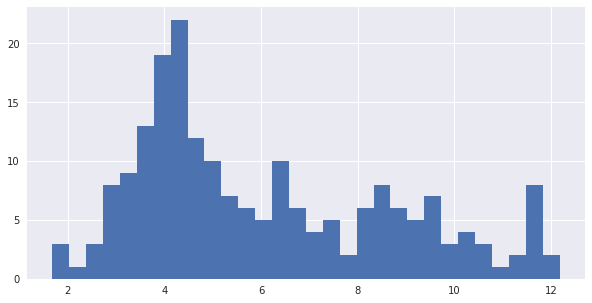

In [61]:
plt.figure(figsize=(10,5))
plt.hist(x, bins=30)
plt.show()

## Spliting the dataset

In [62]:
from sklearn.utils import shuffle # to shuffle the set of data

In [63]:
x_new = shuffle(x, random_state=0)

In [64]:
print('----before suffle----')
print(x[0:2])
print('----after suffle----')
print(x_new[0:2])

----before suffle----
[[2.08025031]
 [5.0830064 ]]
----after suffle----
[[4.93467815]
 [8.81752185]]


The idea is "We are mixing the entire dataset" and break with the order of the simulation. Next we will define a **train set** and **test set**.<br>
Theoretically,
- Train set: It is used to fit the model parameters (or hyperparameters)
- Test set: It is used to test the model using the previously fitted parameters (or hyperparameters)


In [65]:
x_size = x_new.shape[0] # Dataset Length
pct_train = 0.8 # Percentage of train

x_train = x_new[0:int(x_size*pct_train)]
x_test  = x_new[int(x_size*pct_train):]

In [66]:
print(x_train.shape)
print(x_test.shape)

(160, 1)
(40, 1)


## Fitting Kernel Density Estimation

In [67]:
from sklearn.model_selection import GridSearchCV # To compute cross-validation

In [69]:
params = {'bandwidth': np.logspace(-3, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(x_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([0.001  , 0.00144, 0.00207, 0.00298, 0.00428, 0.00616, 0.00886,
       0.01274, 0.01833, 0.02637, 0.03793, 0.05456, 0.07848, 0.11288,
       0.16238, 0.23357, 0.33598, 0.48329, 0.69519, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
pdf_KDE = grid.best_estimator_ # The best model from cross-validation

## Fitting Gaussian Mixture 

In [77]:
from sklearn.mixture import GaussianMixture 

In [80]:
Ns = np.arange(20) + 1 
models = []
for i in range(len(Ns)):
    models.append(GaussianMixture(Ns[i]).fit(x_train)) # sklearn 0.18

In [83]:
# compute the AIC and the BIC
AIC = [m.aic(x_train) for m in models]
BIC = [m.bic(x_train) for m in models]

In [89]:
pdf_GMM = models[np.argmin(BIC)] # The best model based on the BIC criterion.

## Selecting the best model

Now we shall use the **test set**. Consequently, we will obtain the best estimation using both models on a set of data that never seen before

In [153]:
kde_score = pdf_KDE.score_samples(x_test).mean()
gmm_score = pdf_GMM.score_samples(x_test).mean()

In [154]:
print('kde score {0}'.format(kde_score))
print('gmm score {0}'.format(gmm_score))

kde score -2.39210012984
gmm score -2.40585598946


In this case, the best model is obtained when we use KDE.

## Plotting results

In [155]:
def calculate_bins(x):
    dh = 3.5 * x.std()/(len(x)**(1./3.))
    b = int(np.round((x.max() - x.min())/dh)) 
    return b

In [163]:
n = 1000
x_1 = np.random.normal(mu1,sigma1,(1,n)).T
x_2 = np.random.normal(mu2,sigma2,(1,n)).T

In [ ]:
results1 = np.exp(pdf_GMM.score_samples(x_test))
results1 = np.reshape(results1, (results.shape[0], 1))

results2 = np.exp(pdf_KDE.score_samples(x_test))
results2 = np.reshape(results2, (results.shape[0], 1))

/home/koskovi/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/koskovi/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


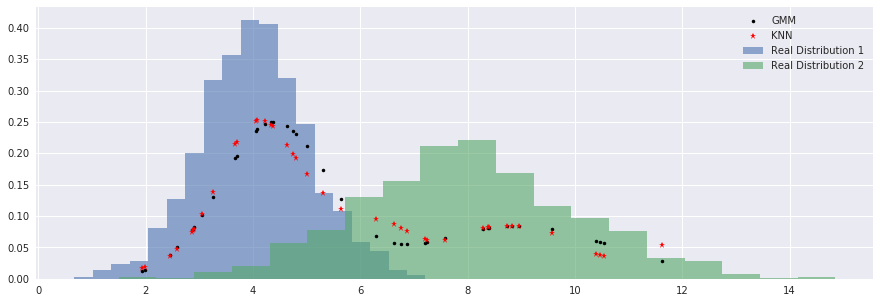

In [184]:
plt.figure(figsize=(15,5))
plt.hist(x_1, bins=calculate_bins(x_1), alpha=0.6, normed = True, label='Real Distribution 1')
plt.hist(x_2, bins=calculate_bins(x_2), alpha=0.6, normed = True, label='Real Distribution 2')
plt.plot(x_test, results1, 'k.', label='GMM')
plt.plot(x_test, results2, 'r*', label='KNN')
plt.legend()
plt.show()